In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

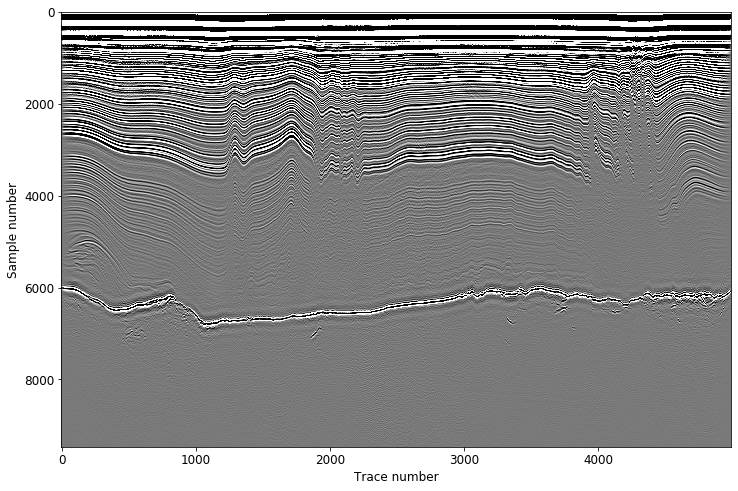

In [3]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [7]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [8]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [9]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



### What we may need is some way to color these contours by power or some similarity metric (coherence?) and not by index (because the contours are not in order).

In [10]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

38
44400
298
30373


In [11]:
#isolate some contours
last_long_idx = long_contours_pos[-30:]
last_long_contours = [pos[idx] for idx in last_long_idx]

In [12]:
argx1 = np.argmin(last_long_contours[0][:, 1])
argx2 = np.argmax(last_long_contours[0][:, 1])

In [13]:
print(argx1, argx2)

406 847


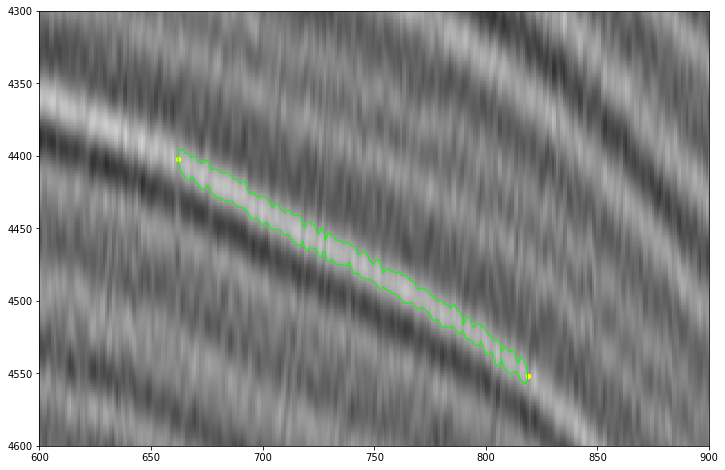

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=20)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=20)

plt.xlim([600, 900])
plt.ylim([4600, 4300])
    
plt.show()

In [15]:
saved_x = []
saved_points = []

In [16]:
uniquex = (list(set([int(x) for x in last_long_contours[0][:, 1]])))
print(uniquex)

[662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818]


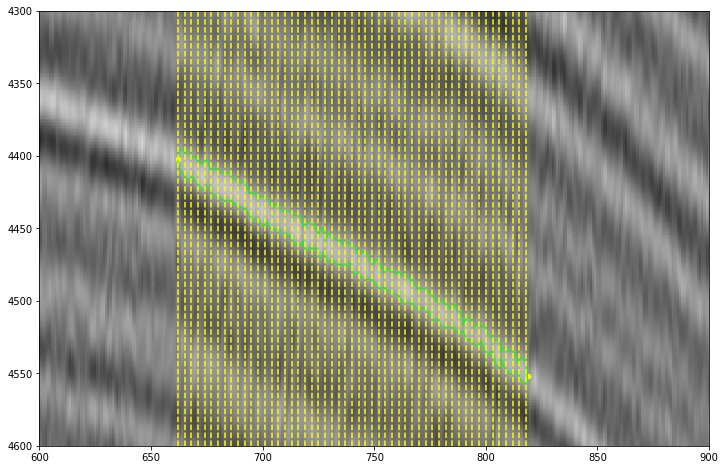

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=20)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=20)

for x in uniquex[::3]:
    ax.axvline(x=x, color='yellow', linestyle='--')

plt.xlim([600, 900])
plt.ylim([4600, 4300])
    
plt.show()

In [18]:
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(last_long_contours[0][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points.append(wherex[1:3])
            print(i, wherex[1:3])
        else:
            saved_points.append(wherex)
            print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]

print('\n', len(uniquex))

1 [399 413]
2 [395 414]
3 [392 417]
4 [389 418]
5 [387 420]
6 [384 423]
7 [383 424]
8 [379 425]
9 [376 429]
10 [373 431]
11 [370 432]
12 [368 433]
13 [365 436]
14 [364 441]
15 [358 445]
16 [356 446]
17 [354 448]
18 [351 450]
19 [350 452]
20 [349 454]
21 [346 455]
22 [344 456]
23 [342 458]
24 [341 460]
25 [339 463]
26 [336 464]
27 [334 467]
28 [333 469]
29 [331 471]
30 [330 472]
31 [327 477]
32 [323 482]
33 [320 483]
34 [319 484]
35 [317 487]
36 [315 489]
37 [311 490]
38 [308 492]
39 [305 494]
40 [303 496]
41 [299 499]
42 [295 503]
43 [293 505]
44 [292 509]
45 [291 511]
46 [289 515]
47 [286 517]
48 [284 520]
49 [282 523]
50 [280 524]
51 [277 528]
52 [273 530]
53 [271 532]
54 [268 534]
55 [266 535]
56 [262 542]
57 [255 545]
58 [253 549]
59 [250 551]
60 [249 553]
61 [248 555]
62 [247 559]
63 [241 563]
64 [238 566]
65 [233 569]
66 [231 579]
67 [223 583]
68 [222 586]
69 [220 589]
70 [217 591]
71 [215 593]
72 [214 595]
73 [212 596]
74 [211 599]
75 [209 600]
76 [206 602]
77 [204 604]
78 [198 

In [19]:
print('saved x\n', uniquex[0:10], '\n')
print('saved points\n', saved_points[0:10], '\n')

saved x
 [663, 664, 665, 666, 667, 668, 669, 670, 671, 672] 

saved points
 [array([399, 413]), array([395, 414]), array([392, 417]), array([389, 418]), array([387, 420]), array([384, 423]), array([383, 424]), array([379, 425]), array([376, 429]), array([373, 431])] 



In [20]:
print(np.shape(uniquex))
print(np.shape(saved_points))

(156,)
(156, 2)


In [21]:
for i, point in enumerate(saved_points):
    print(i, point)

0 [399 413]
1 [395 414]
2 [392 417]
3 [389 418]
4 [387 420]
5 [384 423]
6 [383 424]
7 [379 425]
8 [376 429]
9 [373 431]
10 [370 432]
11 [368 433]
12 [365 436]
13 [364 441]
14 [358 445]
15 [356 446]
16 [354 448]
17 [351 450]
18 [350 452]
19 [349 454]
20 [346 455]
21 [344 456]
22 [342 458]
23 [341 460]
24 [339 463]
25 [336 464]
26 [334 467]
27 [333 469]
28 [331 471]
29 [330 472]
30 [327 477]
31 [323 482]
32 [320 483]
33 [319 484]
34 [317 487]
35 [315 489]
36 [311 490]
37 [308 492]
38 [305 494]
39 [303 496]
40 [299 499]
41 [295 503]
42 [293 505]
43 [292 509]
44 [291 511]
45 [289 515]
46 [286 517]
47 [284 520]
48 [282 523]
49 [280 524]
50 [277 528]
51 [273 530]
52 [271 532]
53 [268 534]
54 [266 535]
55 [262 542]
56 [255 545]
57 [253 549]
58 [250 551]
59 [249 553]
60 [248 555]
61 [247 559]
62 [241 563]
63 [238 566]
64 [233 569]
65 [231 579]
66 [223 583]
67 [222 586]
68 [220 589]
69 [217 591]
70 [215 593]
71 [214 595]
72 [212 596]
73 [211 599]
74 [209 600]
75 [206 602]
76 [204 604]
77 [198 6

## Now find ridge using x and y bounds

In [23]:
ridge_points = []

In [24]:
for i, point in enumerate(saved_points):
    if(len(point == 2)):
        idx1 = point[0]
        idx2 = point[1]
    elif(len(point > 2)):
        idx1 = point[1]
        idx2 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(last_long_contours[0][idx1, 0])
    y2 = int(last_long_contours[0][idx2, 0])
    
    if len(data[y2:y1, x]) == 0:
        print(i, x, np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
    else:
        print(i, x, np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])

0 663 [4403]
1 664 [4404]
2 665 [4406]
3 666 [4407]
4 667 [4408]
5 668 [4408]
6 669 [4408]
7 670 [4410]
8 671 [4412]
9 672 [4413]
10 673 [4414]
11 674 [4414]
12 675 [4412]
13 676 [4414]
14 677 [4418]
15 678 [4418]
16 679 [4419]
17 680 [4420]
18 681 [4420]
19 682 [4421]
20 683 [4422]
21 684 [4421]
22 685 [4422]
23 686 [4423]
24 687 [4424]
25 688 [4425]
26 689 [4426]
27 690 [4427]
28 691 [4427]
29 692 [4427]
30 693 [4430]
31 694 [4434]
32 695 [4435]
33 696 [4435]
34 697 [4435]
35 698 [4436]
36 699 [4437]
37 700 [4438]
38 701 [4438]
39 702 [4438]
40 703 [4440]
41 704 [4443]
42 705 [4443]
43 706 [4442]
44 707 [4443]
45 708 [4444]
46 709 [4446]
47 710 [4447]
48 711 [4446]
49 712 [4446]
50 713 [4449]
51 714 [4451]
52 715 [4451]
53 716 [4452]
54 717 [4452]
55 718 [4454]
56 719 [4457]
57 720 [4456]
58 721 [4455]
59 722 [4456]
60 723 [4456]
61 724 [4457]
62 725 [4461]
63 726 [4461]
64 727 [4459]
65 728 [4462]
66 729 [4464]
67 730 [4463]
68 731 [4463]
69 732 [4465]
70 733 [4467]
71 734 [4467]
72

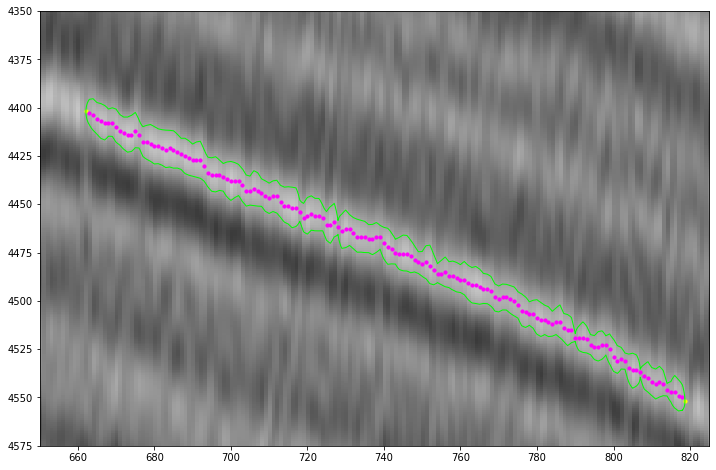

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=10)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=10)

for i, x in enumerate(uniquex):
    y = ridge_points[i]
    ax.scatter(x, y, color='lime', marker='o', s=10)
    
plt.xlim([650, 825])
plt.ylim([4575, 4350])

plt.show()

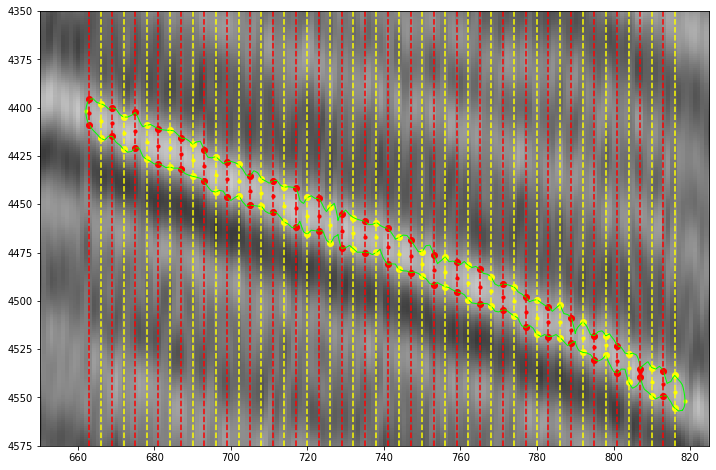

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=10)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=10)

for i, point in enumerate(saved_points[::3]):
        idx1 = point[0]
        idx2 = point[1]
        
        if (i % 2 == 0):
            color='red'
        else:
            color='yellow'
                
        ax.scatter(last_long_contours[0][idx1, 1], last_long_contours[0][idx1, 0], color=color)
        ax.scatter(last_long_contours[0][idx2, 1], last_long_contours[0][idx2, 0], color=color)
        
        ax.scatter(uniquex[::3][i], ridge_points[::3][i], color=color, s=10)
        ax.axvline(uniquex[::3][i], color=color, linestyle='--')

plt.xlim([650, 825])
plt.ylim([4575, 4350])
    
#plt.savefig('middle_of_contours1_lines.pdf', type='pdf', bbox_inches='tight')
plt.show()

## Try to animate these points here

In [30]:
#animate TSI agaist both daisy fraction and temperature
def trace_contours(last_long_contours, argx1, argx2, xlims, ylims, ridge_points, saved):
    
    #make plot interactive
    %matplotlib notebook
    #define figure and axis subplots to plot onto

    fig, ax = plt.subplots(figsize=(12, 8))
    #set grid
    grid = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

    #draw main contour
    ax.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)
    
    #add first and last x point to plot
    ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow')
    ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow')
    
    #add points for top and bottom of contour, as well as for the ridge point
    points1, = ax.plot([], [], color='lime', marker='o')

    #set axis limits (you have to do this explicitly for animations)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    #label x and y axes
    ax.set_xlabel('Trace Number')
    ax.set_ylabel('')

    #set subplot titles here
    ax.set_title('Tracing Contours')
    
    
    #the animation function wants an init_func variable
    #so we initialize all lines to blank
    def init():
        points1.set_data([], [])
        
        return points1,


    #to animate, iterate over the 'frames' parameter
    #each 'idx' is a frame
    def animate(idx):
        points1.set_data(saved[0:idx], ridge_points[0:idx])

        return points1,

    #call our animation function
    anim = FuncAnimation(fig, animate, init_func=init, frames=156, interval=25, repeat=True)
    
    return anim

<IPython.core.display.Javascript object>


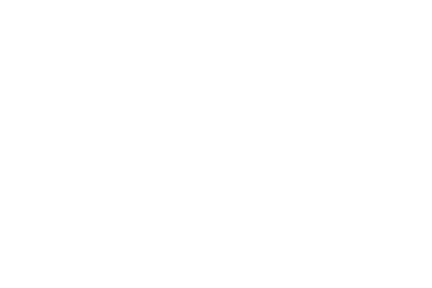

<IPython.core.display.Javascript object>


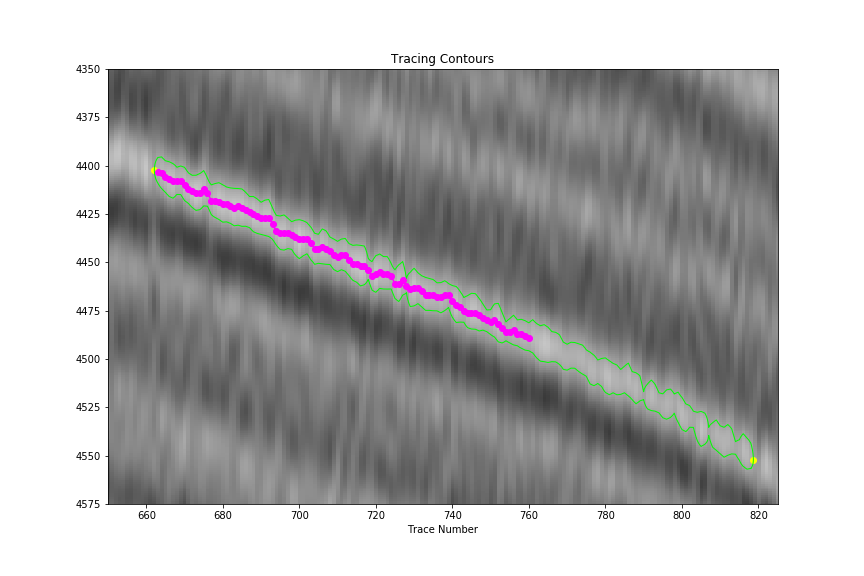

In [33]:
xlims = plt.xlim([650, 825])
ylims = plt.ylim([4575, 4350])

%matplotlib notebook
trace_contours(last_long_contours, argx1, argx2, xlims, ylims, ridge_points, uniquex)